# GPy part

In [2]:
! pip install gpy dynesty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420840 sha256=f5a67864bcefa3c629508909faab911de92e021563ba9d1101a94221dfbd38a3
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=722e022389bf200563e60ed4be53bddeafc3bbad8eb1e63ed1db01867976acf5
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built gpy paramz


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import dynesty as dy
import scipy

%matplotlib inline

# seed the random number generator
rstate = np.random.default_rng(626)

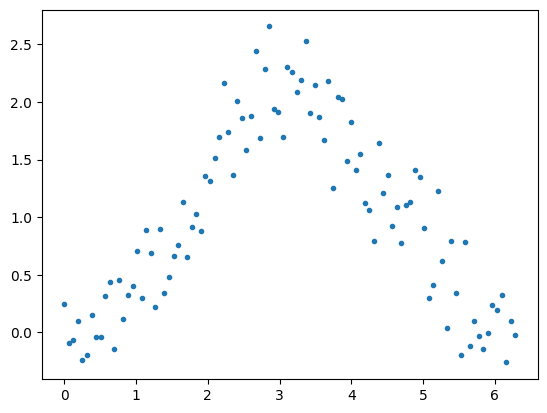

In [3]:
# Let's make some synthetic data
x = np.linspace(0.,2*np.pi,100)[:,None]
y = -np.cos(x)+np.random.randn(*x.shape)*0.3+1
_ = plt.plot(x,y,'.')

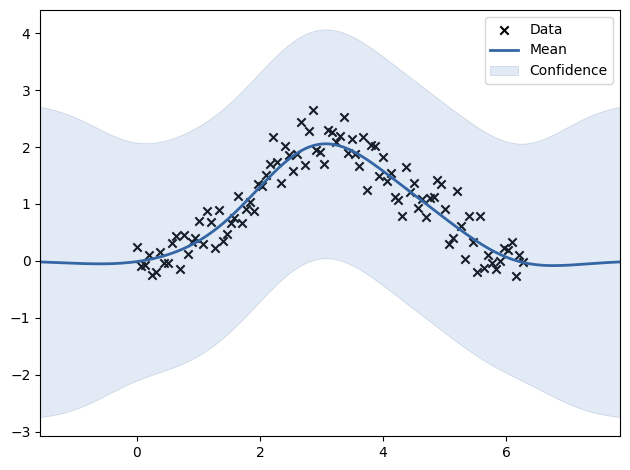

In [4]:
# Make a GP regression model
m = GPy.models.GPRegression(x,y)
# Give some general prior distributions for model parameters
m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
_=m.plot()

In [5]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,"Ga(0.1, 0.1)"
rbf.lengthscale,1.0,+ve,"Ga(0.1, 0.1)"
Gaussian_noise.variance,1.0,+ve,"Ga(0.1, 0.1)"


# Dynesty part

In [6]:
# Set the number of dimensions (parameters) and their bounds
ndim = 3
bounds = [(1e-3, 1e1),(1e-3, 1e1), (1e-3, 1e1)]  # example bounds for RBF variance, RBF lengthscale, and Gaussian noise variance, respectively
epsilon = 1e-10

def negative_log_likelihood(params):
    # Assuming params is a vector of hyperparameters
    kernel = GPy.kern.RBF(input_dim=1, variance=params[0], lengthscale=params[1])
    model = GPy.models.GPRegression(x, y, kernel, noise_var=params[2])

    # Return negative log marginal likelihood
    return -model.log_likelihood()

def prior_transform(u):
    # Map from [0, 1) to Gamma.from_EV(1,10)
    scaled_u = [u_i * (1.0 - epsilon) for u_i in u]
    hyperparameters = [scipy.stats.gamma.ppf(u_i,a=1.0,scale=10.0) for u_i in scaled_u]
    return hyperparameters

In [7]:
# # Define the bounds of the prior space for each hyperparameter
# prior_bounds = [(1e-3, 1e1), (1e-3, 1e1)]

# # Create a grid of parameter values
# param1_values = np.linspace(prior_bounds[0][0], prior_bounds[0][1], 100)
# param2_values = np.linspace(prior_bounds[1][0], prior_bounds[1][1], 100)
# param1_mesh, param2_mesh = np.meshgrid(param1_values, param2_values)
# params_mesh = np.vstack([param1_mesh.ravel(), param2_mesh.ravel()]).T

# # Compute the negative log-likelihood for each point in the parameter space
# negative_log_likelihood_values = np.array([negative_log_likelihood(params) for params in params_mesh])

# # Reshape the values for contour plotting
# negative_log_likelihood_values = negative_log_likelihood_values.reshape(param1_mesh.shape)

# # Plot the contour plot
# plt.contourf(param1_mesh, param2_mesh, negative_log_likelihood_values, cmap='viridis', levels=100)
# plt.colorbar(label='Negative Log-Likelihood')
# plt.xlabel('Parameter 1')
# plt.ylabel('Parameter 2')
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.title('Negative Log-Likelihood Contour Plot')
# plt.show()

In [8]:
# Create a nested sampler
# sampler = dy.NestedSampler(negative_log_likelihood, prior_transform, ndim=ndim, nlive=1500, sample='auto')

In [9]:
# sampler.run_nested()
# results = sampler.results

In [10]:
sampler_dyn = dy.DynamicNestedSampler(negative_log_likelihood, prior_transform, ndim=ndim, nlive=1500, bound='multi', sample='unif', update_interval=50., rstate=rstate)
sampler_dyn.run_nested(maxiter=5000, use_stop=False)
results_dyn = sampler_dyn.results

5001it [09:21,  3.14it/s, batch: 0 | bound: 0 | nc: 65 | ncall: 40633 | eff(%): 11.870 | loglstar:   -inf < 272.722 <    inf | logz: 266.670 +/-  0.057 | dlogz: 43642.590 >  0.010] /usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning:The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
6501it [09:21, 11.58it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 42133 | eff(%): 15.430 | loglstar:   -inf < 43912.582 <    inf | logz: 43901.242 +/-  0.220 | dlogz:  1.099 >  0.010] 


In [11]:
best_fit_params = results_dyn.samples[np.argmin(results_dyn.logl)]
print(best_fit_params)

[5.60017592 2.44283531 0.08062138]



Name : GP regression
Objective : 44.807170951072706
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors   
  rbf.variance             |    5.600175924370645  |      +ve      |  Ga(0.1, 0.1)
  rbf.lengthscale          |   2.4428353084135805  |      +ve      |  Ga(0.1, 0.1)
  Gaussian_noise.variance  |  0.08062138107322184  |      +ve      |  Ga(0.1, 0.1)


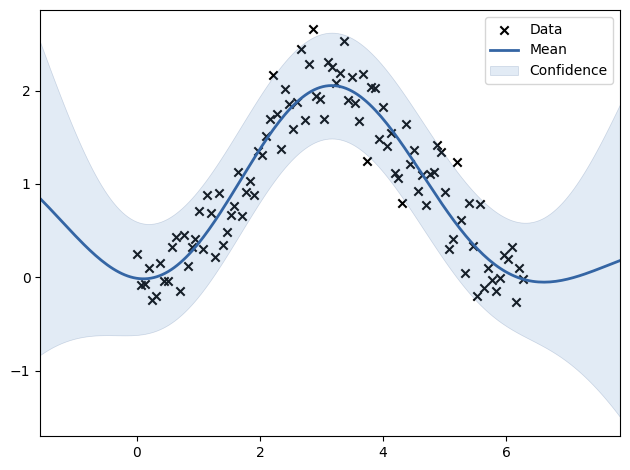

In [12]:
# Set the model parameters as the posterior mean
m.kern.variance = best_fit_params[0]
m.kern.lengthscale = best_fit_params[1]
m.likelihood.variance = best_fit_params[2]
print(m)
_=m.plot()

# Application to light curve

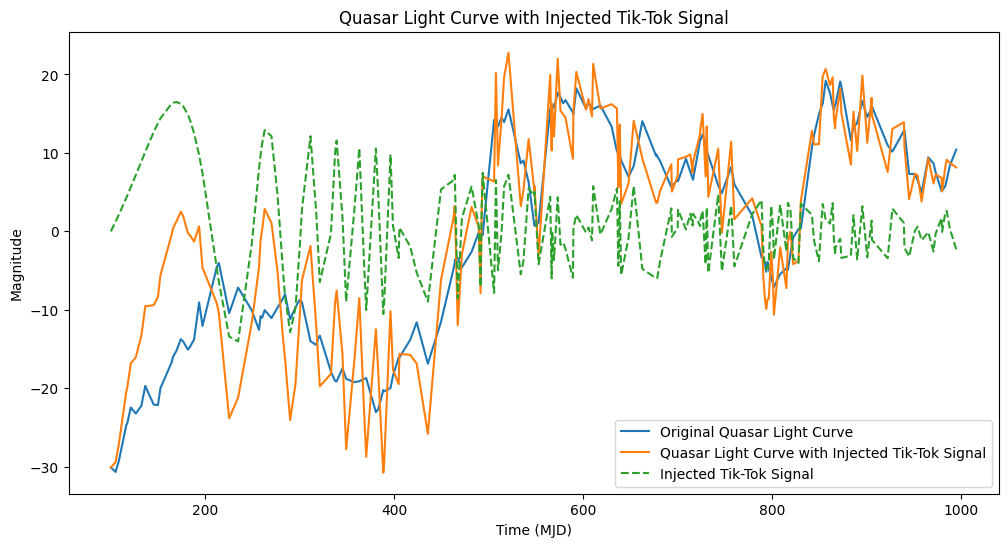

In [4]:
from scipy.interpolate import interp1d

np.random.seed(113)

def generate_red_noise(time_instances, sigma=0.1):
    delta_t = np.diff(time_instances, prepend=time_instances[0])
    disturbances = np.random.normal(scale=sigma, size=len(time_instances))
    red_noise = np.cumsum(delta_t * disturbances)
    # print(np.max(disturbances))
    return red_noise - red_noise.mean()

def generate_tiktok_signal(time_instances, initial_period, damping_factor_amplitude, damping_factor_frequency):
    frequency = 1 / (initial_period * np.exp(-damping_factor_frequency * time_instances))
    amplitude = np.exp(-damping_factor_amplitude * time_instances)
    tiktok_signal = amplitude * np.sin(2 * np.pi * frequency * time_instances)
    return tiktok_signal

def inject_tiktok_to_light_curve(real_times, real_light_curve, initial_period, damping_factor_amplitude, damping_factor_frequency, snr=None, inject_signal=False):
    if not inject_signal:
        return real_light_curve, np.zeros_like(real_light_curve)

    t = np.linspace(real_times.min(), real_times.max(), 5 * len(real_times))
    tiktok_signal_regular = generate_tiktok_signal(t - t.min(), initial_period, damping_factor_amplitude, damping_factor_frequency)

    if snr is not None:
        noise_power = np.var(real_light_curve)
        signal_power = noise_power * snr
        scale_factor = np.sqrt(signal_power)
        tiktok_signal_regular *= scale_factor

    interpolator = interp1d(t, tiktok_signal_regular, kind='linear', fill_value="extrapolate")
    tiktok_signal_interpolated = interpolator(real_times)

    combined_light_curve = real_light_curve + tiktok_signal_interpolated
    return combined_light_curve, tiktok_signal_interpolated

real_times = np.sort(np.random.uniform(100, 1000, 200))
real_light_curve = generate_red_noise(real_times, sigma=0.5)  # Adjust sigma as needed

initial_period = 500
damping_factor_amplitude = 0.002
damping_factor_frequency = 0.008
snr = 2
inject_signal = True

combined_light_curve, tiktok_signal = inject_tiktok_to_light_curve(
    real_times,
    real_light_curve,
    initial_period,
    damping_factor_amplitude,
    damping_factor_frequency,
    snr,
    inject_signal
)

plt.figure(figsize=(12, 6))
plt.plot(real_times, real_light_curve, label='Original Quasar Light Curve')
if inject_signal:
    plt.plot(real_times, combined_light_curve, label='Quasar Light Curve with Injected Tik-Tok Signal')
    plt.plot(real_times, tiktok_signal, label='Injected Tik-Tok Signal', linestyle='--')
plt.xlabel('Time (MJD)')
plt.ylabel('Magnitude')
plt.title('Quasar Light Curve with Injected Tik-Tok Signal')
plt.legend()
plt.show()


In [25]:
print(np.shape(np.reshape(combined_light_curve, (200, 1))[:50]))

(50, 1)


In [20]:
GPy.kern.StdPeriodic()

(500.0, 700.0)

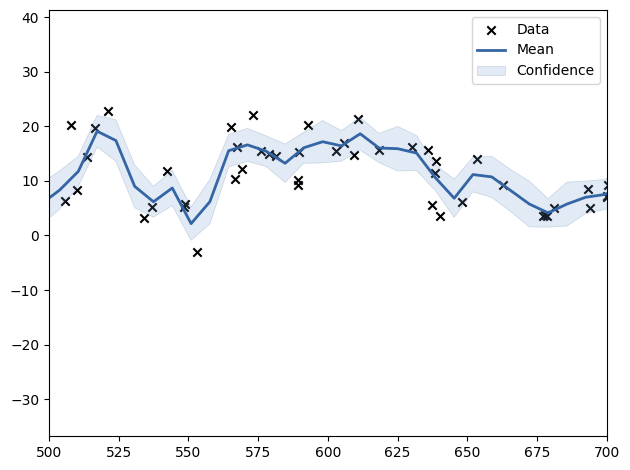

In [37]:
# Make a GP regression model
ker1 = GPy.kern.Brownian(1)
ker2 = GPy.kern.StdPeriodic(input_dim=1, period=500)
# ker2.period.constrain_bounded(1.0,500.0)
m_lc = GPy.models.GPRegression(np.reshape(real_times, (len(real_times),1)),np.reshape(combined_light_curve, (len(combined_light_curve),1)), ker1+ker2)
# Give some general prior distributions for model parameters
# m_lc.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
# m_lc.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
# m_lc.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
_=m_lc.plot()
plt.xlim(500,700)

In [38]:
m_lc

GP_regression.,value,constraints,priors
sum.Brownian.variance,1.0,+ve,
sum.std_periodic.variance,1.0,+ve,
sum.std_periodic.period,500.0,+ve,
sum.std_periodic.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [43]:
# Set the number of dimensions (parameters) and their bounds
ndim = 4
bounds = [(1e-3, 1e1),(1e-3, 1e1), (1e-3, 1e1), (1e-3, 1e1)]
epsilon = 1e-10

def negative_log_likelihood(params):
    # Assuming params is a vector of hyperparameters
    ker1 = GPy.kern.Brownian(input_dim=1, variance=params[0])
    ker2 = GPy.kern.StdPeriodic(input_dim=1, variance=params[1], period=500, lengthscale=params[2])
    model = GPy.models.GPRegression(np.reshape(real_times, (len(real_times),1)), np.reshape(combined_light_curve, (len(combined_light_curve),1)), ker1+ker2, noise_var=params[3])

    # Return negative log marginal likelihood
    return -model.log_likelihood()

def prior_transform(u):
    # Map from u in [0, 1) to the parameter space
    # scaled_u = [u_i * (1.0 - epsilon) for u_i in u]
    hyperparameters = [bounds[i][0] + u_i * (bounds[i][1] - bounds[i][0]) for i, u_i in enumerate(u)]
    return hyperparameters

In [44]:
sampler_dyn = dy.DynamicNestedSampler(negative_log_likelihood, prior_transform, ndim=ndim, nlive=1500, bound='multi', sample='unif', update_interval=50., rstate=rstate)
sampler_dyn.run_nested(maxiter=5000, use_stop=False)
results_dyn = sampler_dyn.results

5001it [23:50,  2.46it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 40893 | eff(%): 11.797 | loglstar:   -inf < 919.285 <    inf | logz: 910.717 +/-  0.072 | dlogz: 23560.120 >  0.010] /usr/local/lib/python3.10/dist-packages/dynesty/sampler.py:756: UserWarning:The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
6501it [23:50,  4.54it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 42393 | eff(%): 15.335 | loglstar:   -inf < 24474.037 <    inf | logz: 24462.697 +/-  0.133 | dlogz:  1.099 >  0.010]   


In [45]:
best_fit_params = results_dyn.samples[np.argmin(results_dyn.logl)]
print(best_fit_params)

[5.64070411 3.64419025 5.05491558 6.10833277]



Name : GP regression
Objective : 626.3237170318248
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                |               value  |  constraints  |  priors
  sum.Brownian.variance         |   5.640704109242959  |      +ve      |        
  sum.std_periodic.variance     |  3.6441902504075934  |      +ve      |        
  sum.std_periodic.period       |               500.0  |      +ve      |        
  sum.std_periodic.lengthscale  |    5.05491558045507  |      +ve      |        
  Gaussian_noise.variance       |     6.1083327679184  |      +ve      |        


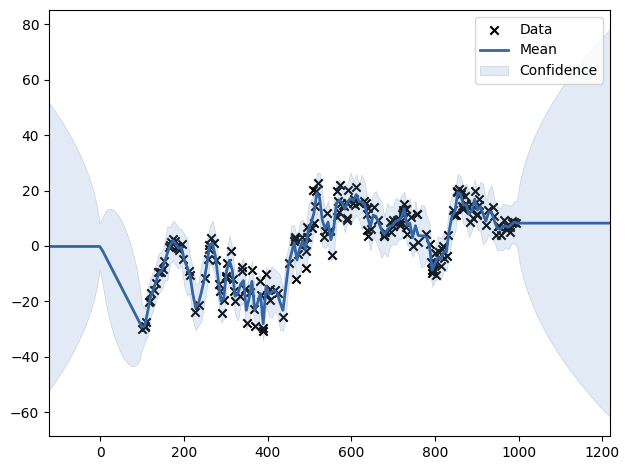

In [47]:
# Set the model parameters as the posterior mean
m_lc.sum.Brownian.variance = best_fit_params[0]
m_lc.sum.std_periodic.variance = best_fit_params[1]
m_lc.sum.std_periodic.lengthscale = best_fit_params[2]
m_lc.likelihood.variance = best_fit_params[3]
print(m_lc)
_=m_lc.plot()
# plt.xlim(500,700)


Name : GP regression
Objective : 1773.5111778579455
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                |         value  |  constraints  |  priors
  sum.Brownian.variance         |   0.608814953  |      +ve      |        
  sum.std_periodic.variance     |    7.15734343  |      +ve      |        
  sum.std_periodic.period       |    193.937716  |      +ve      |        
  sum.std_periodic.lengthscale  |    7.18950583  |      +ve      |        
  Gaussian_noise.variance       |  0.0828325714  |      +ve      |        


# Using GPflow

In [17]:
!pip install gpflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.8/379.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 13.3 MB/s eta 0:00:00


In [ ]:
import gpflow

mod_gpf =